환경 설정

!!!!! 경로설정만 잘 해주세요 !!!!!!
조금 난잡하게 하긴 했는데 그건 봐주세요!!!!!

In [ ]:
import os
import re
import json
import numpy as np
import cv2
import struct
import torch
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
from tqdm import tqdm  # tqdm 임포트

# bin 파일 생성 경로
LABEL_ROOT = "./data/train/outputs_json"  # JSON 파일의 루트 폴더 경로
OUTPUT_ROOT = "./custom_data/train/outputs_json"  # 변환된 bin 파일을 저장할 루트 폴더 경로
IMAGE_ROOT = "./data/train/DCM"  # 이미지 파일 루트 경로

#####아래 경로는 train, test를 다 변경해야 하기 때문에 './data'로 전체 데이터셋을 설정해야 함
# npy 생성 경로
data_folder = './data'
# npy 파일을 저장할 새로운 폴더 경로
output_folder = './custom_data'

##### 아래 경로는 kfold를 통해 생성된 json 파일들의 .png와 .json을 변경해줄 때 사용하는 경로입니다.
##### 만약 kfold를 안쓰시고 계시면 수정할 필요는 없습니다.
kfold_folder = './data/kfold_splits'
output_kfold_folder = './custom_data/kfold_splits'


# Ensure output directory exists
os.makedirs(OUTPUT_ROOT, exist_ok=True)

# 클래스 정의
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

# 클래스 이름을 인덱스로 매핑
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Polygon to Mask (Json -> Bin) ::: (예상 소요 시간: 15분)

In [2]:
def polygon_to_mask(polygons, height, width, class_id):
    """Convert polygon data to dense mask format with class-specific values."""
    mask = np.zeros((height, width), dtype=np.uint8)
    for polygon in polygons:
        points = np.array(polygon, dtype=np.int32)
        cv2.fillPoly(mask, [points], class_id)  # 각 클래스에 고유한 ID로 채움
    return mask

def compress_and_save_mask(mask, output_path):
    """Compress the mask into binary and save it."""
    num_classes = mask.shape[-1]  # Calculate the number of classes
    # Flatten and pack each class mask into binary
    packed_masks = np.packbits(mask, axis=None)

    with open(output_path, 'wb') as f:
        f.write(struct.pack('ii', mask.shape[0], mask.shape[1]))  # height, width
        f.write(packed_masks.tobytes())  # Write the packed masks

def process_all_jsons(label_root, output_root, image_root):
    # 전체 파일을 대상으로 tqdm을 사용하여 진행 상황을 표시
    for root, dirs, files in tqdm(os.walk(label_root), desc="Processing JSON files", total=len(os.listdir(label_root))):
        for json_file in files:
            if json_file.endswith(".json"):
                json_path = os.path.join(root, json_file)

                # Find the corresponding PNG file path
                relative_path = os.path.relpath(root, label_root)
                image_dir = os.path.join(image_root, relative_path)
                image_path = os.path.join(image_dir, os.path.splitext(json_file)[0] + ".png")

                # Check if the corresponding image exists
                if not os.path.exists(image_path):
                    print(f"Warning: Corresponding image not found for {json_path}. Skipping file.")
                    continue

                # Load image to get height and width
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Error: Could not read image at {image_path}. Skipping file.")
                    continue
                height, width = image.shape

                # Load JSON data
                with open(json_path, 'r') as f:
                    data = json.load(f)

                # Initialize an empty mask with 29 channels (one per class)
                mask = np.zeros((height, width, len(CLASSES)), dtype=np.uint8)

                # Process each annotation in the JSON
                for annotation in data.get('annotations', []):
                    label = annotation['label']  # 클래스 이름
                    class_id = CLASS2IND.get(label)  # 클래스 ID로 변환
                    
                    if class_id is None:
                        print(f"Warning: Label '{label}' not found in CLASSES. Skipping.")
                        continue
                    
                    points = annotation['points']  # 폴리곤 점 좌표
                    class_mask = polygon_to_mask([points], height, width, 1)  # 마스크 생성
                    mask[..., class_id] = np.maximum(mask[..., class_id], class_mask)  # 각 클래스별로 마스크를 업데이트

                # Preserve subfolder structure in OUTPUT_ROOT
                output_dir = os.path.join(output_root, relative_path)
                os.makedirs(output_dir, exist_ok=True)
                
                output_path = os.path.join(output_dir, os.path.splitext(json_file)[0] + ".bin")
                
                # Save the mask as a binary file
                compress_and_save_mask(mask, output_path)

# Run the processing on all JSON files, preserving folder structure
process_all_jsons(LABEL_ROOT, OUTPUT_ROOT, IMAGE_ROOT)


Processing JSON files: 401it [14:05,  2.11s/it]                         


png -> npy ::: (예상 소요 시간: 60초)

In [ ]:
# output 폴더가 없으면 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# data 폴더의 하위 폴더를 순회
for root, dirs, files in os.walk(data_folder):
    # 하위 폴더 안에 있는 파일들을 순회
    for file_name in files:
        if file_name.endswith('.png'):
            # 원본 파일 경로와 새로운 저장 경로 설정
            img_path = os.path.join(root, file_name)
            relative_path = os.path.relpath(root, data_folder)
            save_folder = os.path.join(output_folder, relative_path)
            
            # output 폴더의 하위 폴더가 없으면 생성
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            
            # 이미지 열기
            img = Image.open(img_path)
            img_array = np.array(img)
            
            # 저장할 npy 파일 경로 설정
            npy_file_name = os.path.splitext(file_name)[0] + '.npy'
            npy_file_path = os.path.join(save_folder, npy_file_name)
            
            # npy 형식으로 저장
            np.save(npy_file_path, img_array)


Saved ./custom_data/test/DCM/ID194/image1663034114127.npy
Saved ./custom_data/test/DCM/ID194/image1663034135371.npy
Saved ./custom_data/test/DCM/ID259/image1663724556918.npy
Saved ./custom_data/test/DCM/ID259/image1663724571797.npy
Saved ./custom_data/test/DCM/ID271/image1664154464821.npy
Saved ./custom_data/test/DCM/ID271/image1664154449598.npy
Saved ./custom_data/test/DCM/ID233/image1663636406859.npy
Saved ./custom_data/test/DCM/ID233/image1663636433659.npy
Saved ./custom_data/test/DCM/ID044/image1661320671343.npy
Saved ./custom_data/test/DCM/ID044/image1661320722689.npy
Saved ./custom_data/test/DCM/ID550/image1667354424553.npy
Saved ./custom_data/test/DCM/ID550/image1667354405140.npy
Saved ./custom_data/test/DCM/ID236/image1663636649479.npy
Saved ./custom_data/test/DCM/ID236/image1663636678019.npy
Saved ./custom_data/test/DCM/ID203/image1663117371313.npy
Saved ./custom_data/test/DCM/ID203/image1663117343870.npy
Saved ./custom_data/test/DCM/ID214/image1663118622397.npy
Saved ./custom

KFold json 파일 변경 ::: (예상 소요 시간: 1초)

In [4]:
# output_folder가 없으면 생성
if not os.path.exists(output_kfold_folder):
    os.makedirs(output_kfold_folder)

# 확장자 변경 함수 정의
def replace_extensions(value):
    if isinstance(value, str):
        # .png -> .npy 변경
        value = re.sub(r'\.png$', '.npy', value)
        # .json -> .bin 변경
        value = re.sub(r'\.json$', '.bin', value)
    elif isinstance(value, list):
        # 리스트일 경우, 각 요소에 대해 재귀적으로 처리
        value = [replace_extensions(v) for v in value]
    elif isinstance(value, dict):
        # 딕셔너리일 경우, 각 키의 값에 대해 재귀적으로 처리
        value = {k: replace_extensions(v) for k, v in value.items()}
    return value

# 입력 폴더 내부의 모든 JSON 파일에 대해 반복
for file_name in os.listdir(kfold_folder):
    if file_name.endswith('.json'):
        # JSON 파일 열기
        input_file_path = os.path.join(kfold_folder, file_name)
        with open(input_file_path, 'r') as file:
            data = json.load(file)
        
        # 확장자 변경 적용
        updated_data = replace_extensions(data)
        
        # 수정된 데이터 저장할 파일 경로 설정 (output_folder에 같은 이름의 파일 생성)
        output_kfold_path = os.path.join(output_kfold_folder, file_name)
        with open(output_kfold_path, 'w') as file:
            json.dump(updated_data, file, indent=4, ensure_ascii=False)
        
        print(f"Modified file saved as '{output_kfold_path}'")


Modified file saved as './data/bin_kfold_splits/fold_4.json'
Modified file saved as './data/bin_kfold_splits/fold_1.json'
Modified file saved as './data/bin_kfold_splits/fold_0.json'
Modified file saved as './data/bin_kfold_splits/fold_2.json'
Modified file saved as './data/bin_kfold_splits/fold_3.json'


시각화

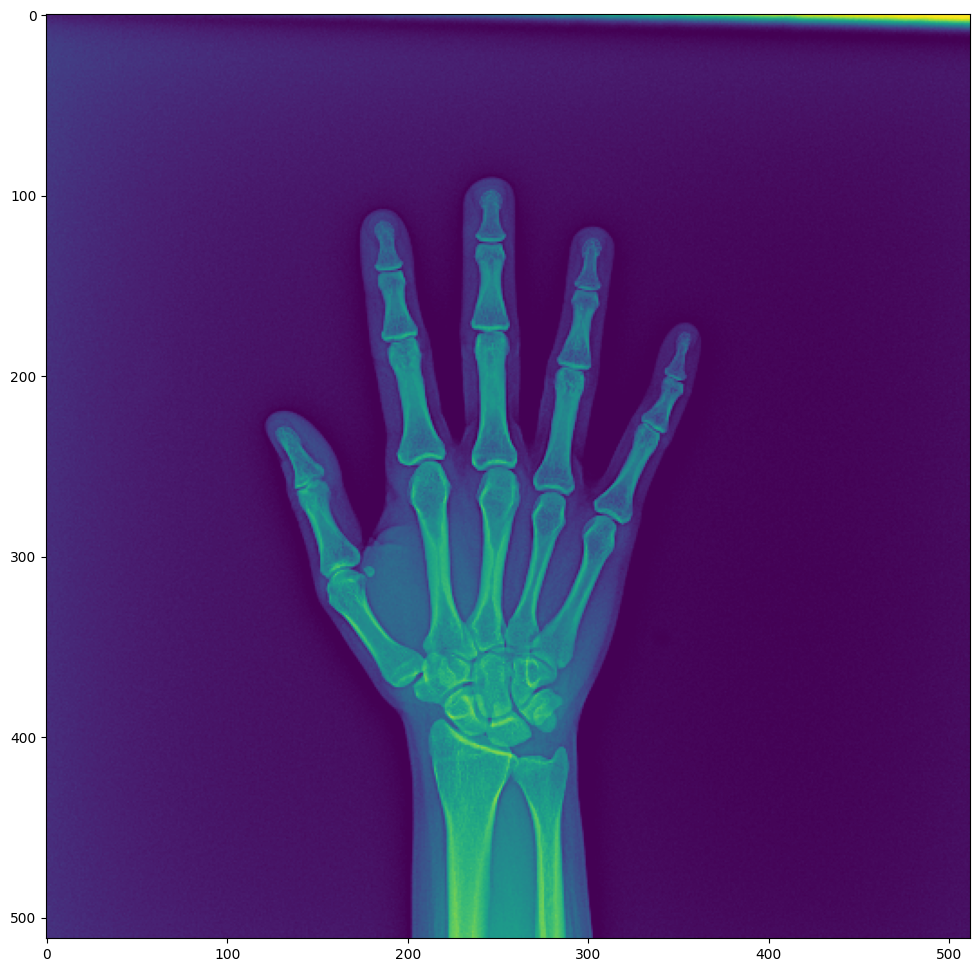

In [5]:
def show_image(image_path):
    image =np.load(image_path)
    image = image / 255.0
    
    if len(image.shape) == 2:  # (H, W) 형태일 경우
        image = np.stack([image] * 3, axis=-1)  # (H, W, 3) 형태로 확장
    
    transforms = A.Resize(512, 512)
    if transforms is not None:
            inputs = {"image": image}
            result = transforms(**inputs)
            image = result["image"]
    
    image = image.transpose(2, 0, 1)
    image = torch.from_numpy(image).float()
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
    
    plt.show()
        
            
show_image('./custom_data/train/DCM/ID025/image1661304399229.npy')

Bin 파일 시각화

Loaded mask shape: (2048, 2048, 29)
Unique values in loaded mask (class IDs): [0 1]


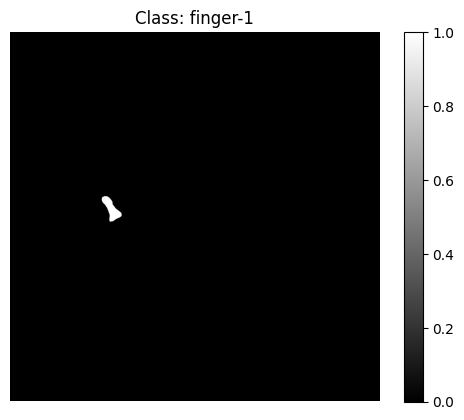

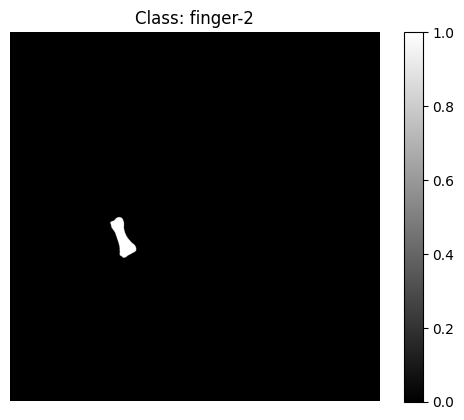

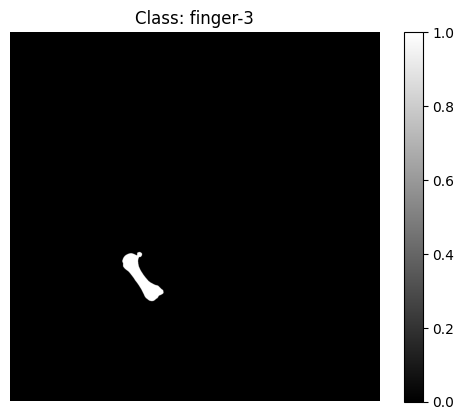

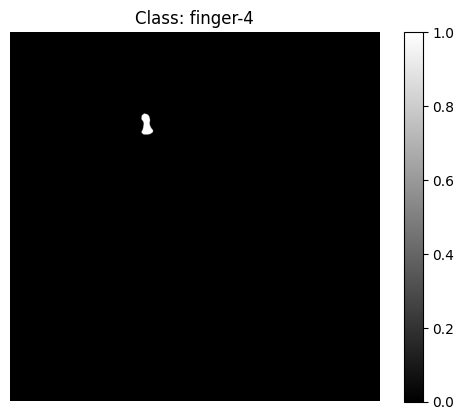

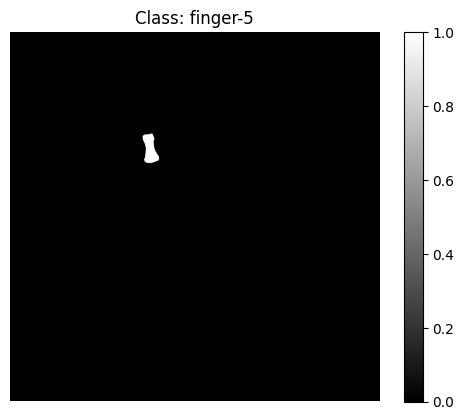

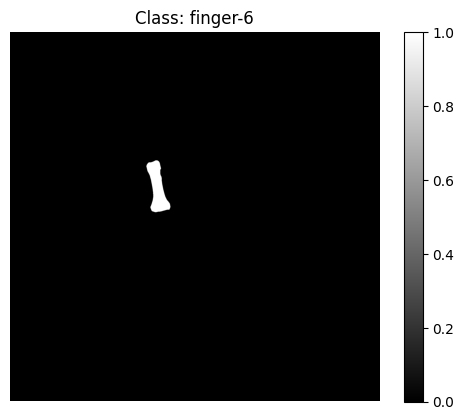

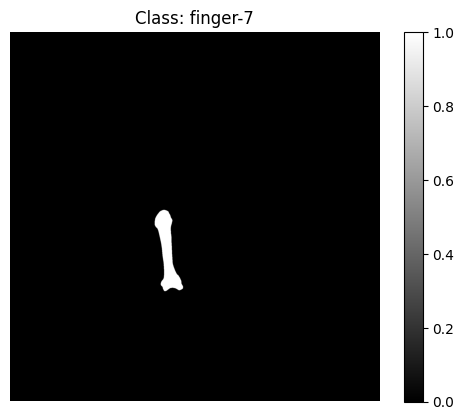

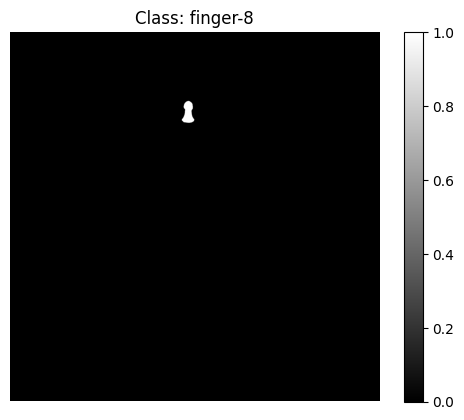

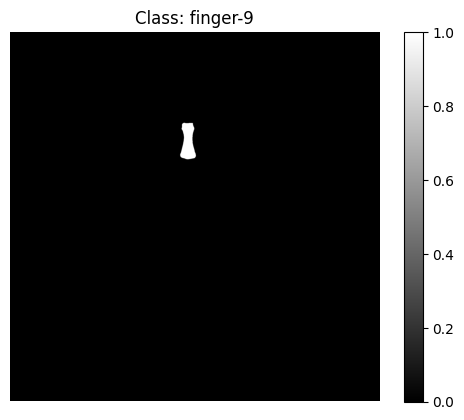

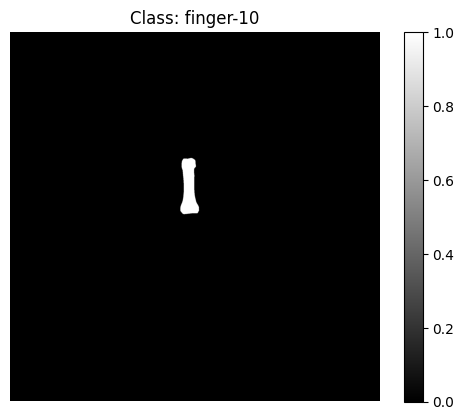

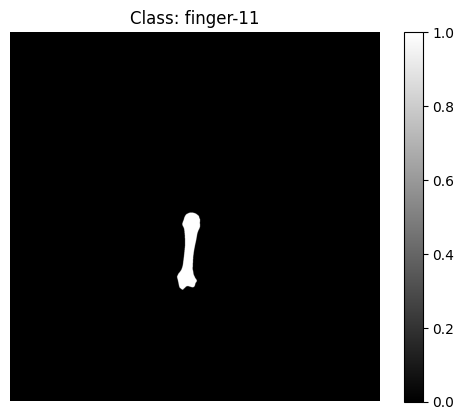

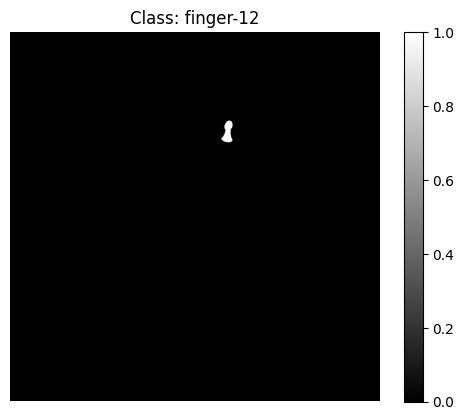

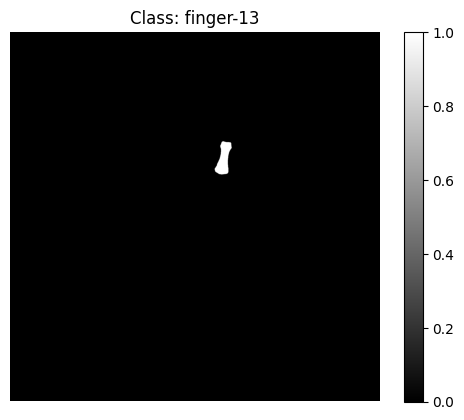

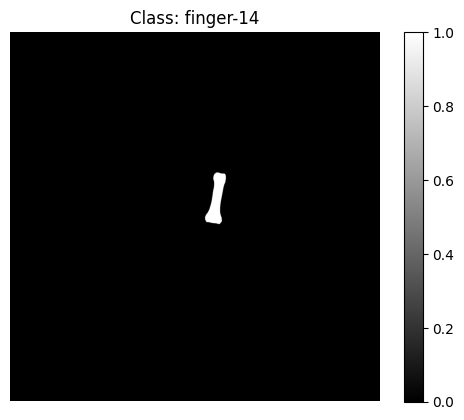

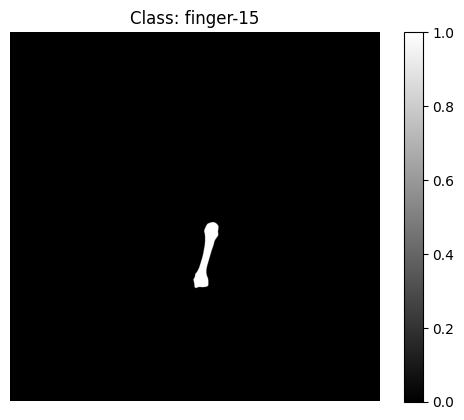

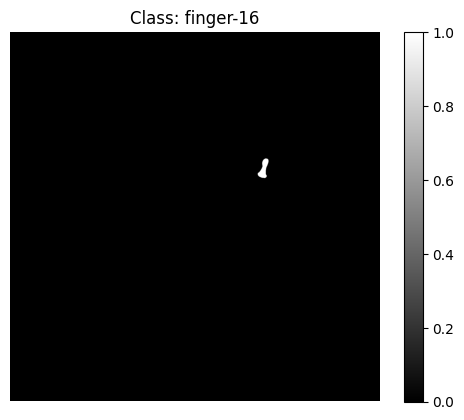

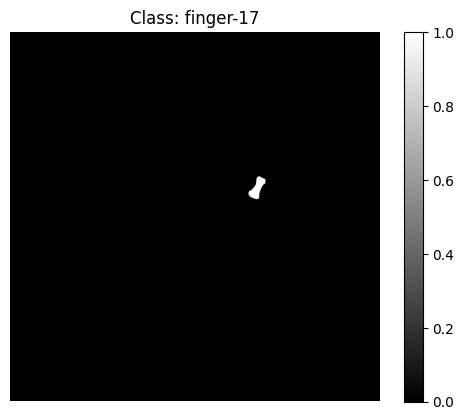

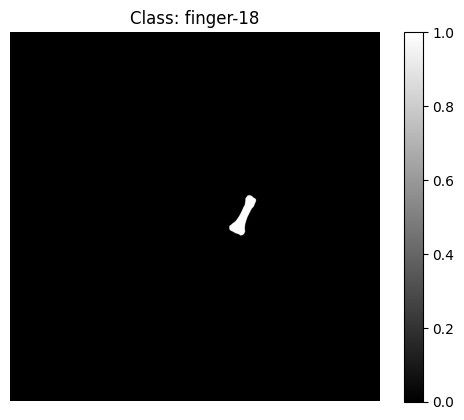

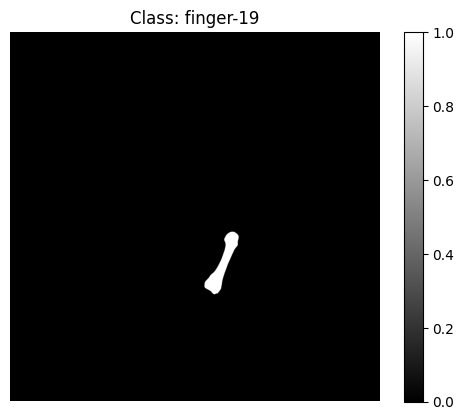

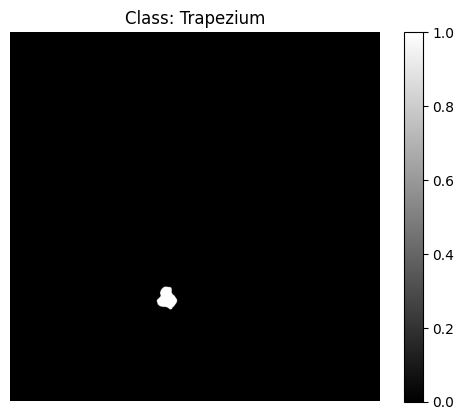

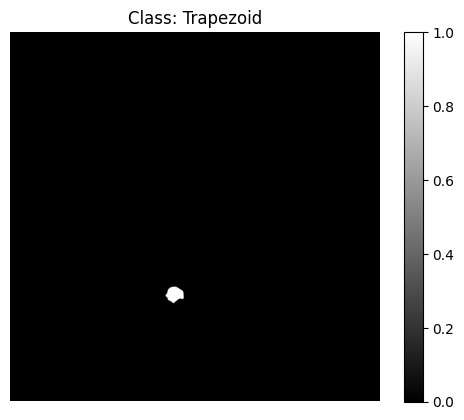

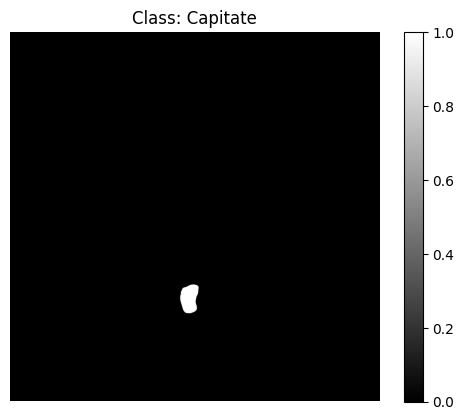

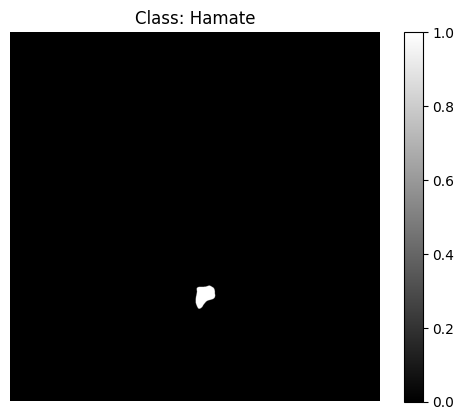

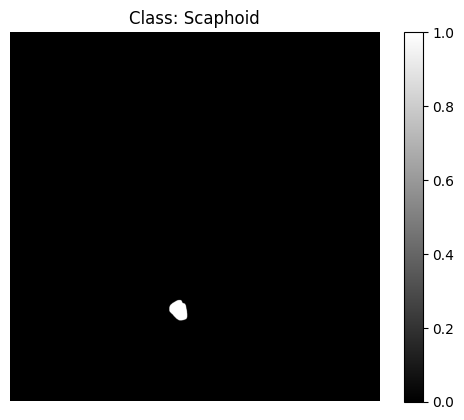

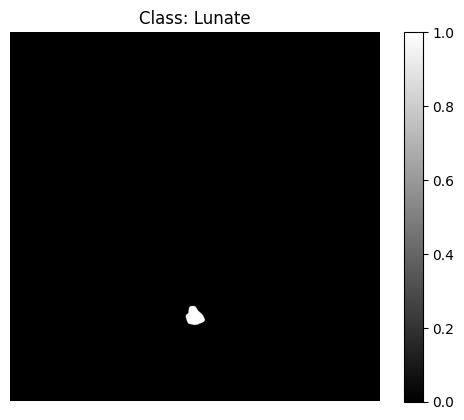

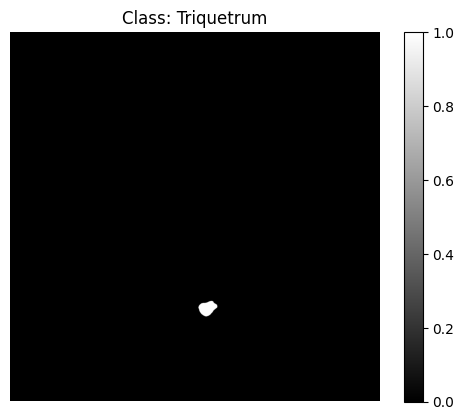

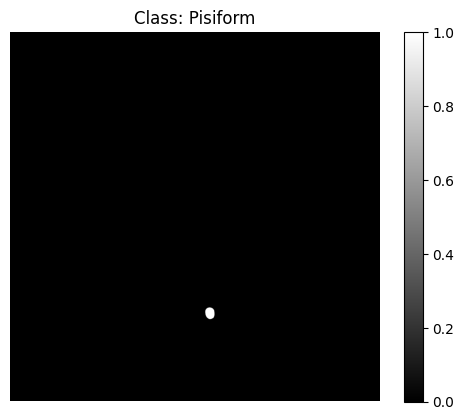

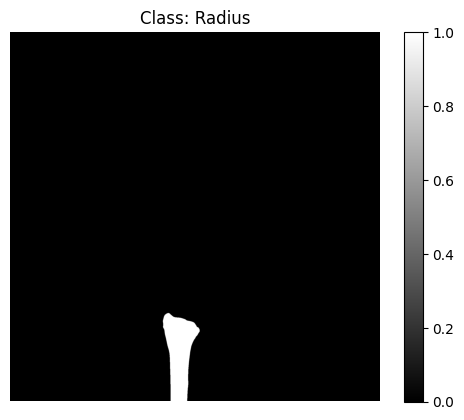

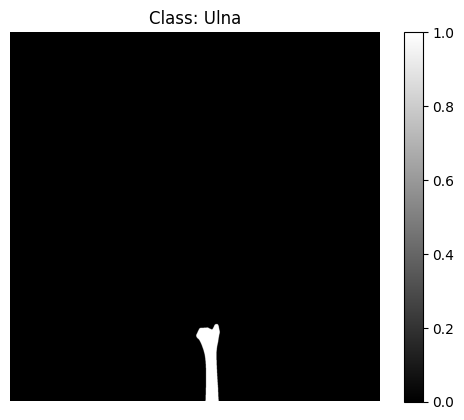

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [6]:
def load_and_split_classes_from_bin(bin_path):
    """Load the bin file and split into class masks."""
    with open(bin_path, "rb") as f:
        # Read the height and width
        height, width = struct.unpack('ii', f.read(8))

        # Read the packed mask data
        packed_mask = np.frombuffer(f.read(), dtype=np.uint8)

        # Calculate the number of classes from the packed mask
        num_classes = len(CLASSES)

        # Unpack bits to get the original flat mask and reshape it to (height, width, num_classes)
        flat_mask = np.unpackbits(packed_mask)[:height * width * num_classes]  # Adjust to handle all classes
        mask = flat_mask.reshape((height, width, num_classes))

        # Visualize and separate the class masks
        print(f"Loaded mask shape: {mask.shape}")
        print("Unique values in loaded mask (class IDs):", np.unique(mask))

        # Visualize the mask for each class
        for class_id in range(num_classes):
            class_mask = mask[..., class_id]
            plt.imshow(class_mask, cmap="gray")
            plt.title(f"Class: {CLASSES[class_id]}")
            plt.colorbar()
            plt.axis('off')
            plt.show()

    return mask

# Example usage:
bin_file_path = "./custom_data/train/outputs_json/ID025/image1661304399229.bin"  # Update this to your .bin file path
load_and_split_classes_from_bin(bin_file_path)